In [1]:
import numpy as np
from metadata_utils import InstanceMNIST
from metadata_utils import collate_fn_2 as collate_fn

from torch.utils.data import DataLoader

import torch

from torch.utils.data import DataLoader

from metadata_utils import InstanceMNIST

from dataeval.detectors.ood.vae import OOD_VAE
from dataeval.utils.torch.models import  AE
from dataeval.utils.dataset.datasets import MNIST

from dataeval.metrics.bias import balance
from dataeval.utils.metadata import preprocess

from tqdm import tqdm
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"



2025-01-15 17:57:27.682807: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-15 17:57:27.690908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-15 17:57:27.700490: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-15 17:57:27.703366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 17:57:27.711001: I tensorflow/core/platform/cpu_feature_guar

In [2]:
corruption_list = ['identity', 'translate', 'shot_noise', 'motion_blur', 'scale']

mnist = InstanceMNIST(corruption_list, size=8000)
mnist_val = InstanceMNIST('identity', train=False, size=8000)

refdata = mnist.identity
valdata = mnist_val.identity
shiftdata = mnist.translate
spikydata = mnist.shot_noise
blurdata = mnist.motion_blur
scaledata = mnist.scale



train is True, MNIST_NUM_IMAGES: 60000
train is False, MNIST_NUM_IMAGES: 10000


In [3]:
# Load in the training mnist dataset and use the first 2000
train_ds = MNIST(root="./data/", train=True, download=True, size=2000, unit_interval=True, channels="channels_first")
val_ds = MNIST(root="./data/", train=False, download=True, size=2000, unit_interval=True, channels="channels_first")

# Split out the images and labels
images, labels = train_ds.data, train_ds.targets
val_images, val_labels  = val_ds.data, val_ds.targets

input_shape = images[0].shape

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# from metadata_tools import ks_compare

big_batch_size = 2000
collate_fn = collate_fn

refbb = DataLoader(refdata, collate_fn=collate_fn, batch_size=big_batch_size)

valbb = DataLoader(valdata, collate_fn=collate_fn, batch_size=big_batch_size)
corr1bb = DataLoader(shiftdata, collate_fn=collate_fn, batch_size=big_batch_size)
corr2bb = DataLoader(spikydata, collate_fn=collate_fn, batch_size=big_batch_size)
corr3bb = DataLoader(blurdata, collate_fn=collate_fn, batch_size=big_batch_size)
corr4bb = DataLoader(scaledata, collate_fn=collate_fn, batch_size=big_batch_size)


In [5]:
for data, labels, md in valbb:
    break

In [6]:
mdnf = preprocess(md, labels)

/workspaces/dataeval/src/dataeval/utils/metadata.py:413: UserWarning: A user defined binning was not provided for fill_frac. Using the uniform_width method to discretize the data. It is recommended that the user rerun and supply the desired bins using the continuous_factor_bins parameter.
  warnings.warn(
/workspaces/dataeval/src/dataeval/utils/metadata.py:413: UserWarning: A user defined binning was not provided for cm_y. Using the uniform_width method to discretize the data. It is recommended that the user rerun and supply the desired bins using the continuous_factor_bins parameter.
  warnings.warn(
/workspaces/dataeval/src/dataeval/utils/metadata.py:413: UserWarning: A user defined binning was not provided for random. Using the uniform_width method to discretize the data. It is recommended that the user rerun and supply the desired bins using the continuous_factor_bins parameter.
  warnings.warn(
/workspaces/dataeval/src/dataeval/utils/metadata.py:413: UserWarning: A user defined bi

In [7]:
# mbal = balance(mdpp) # takes 47 seconds


In [8]:
mdnf.continuous_factor_names

['fill_frac', 'cm_y', 'random', 'spikiness', 'cm_x']

In [9]:
mdnf.discrete_factor_names

['fill_frac',
 'cm_y',
 'width',
 'y_ctr',
 'isolated_pixels',
 'random',
 'spikiness',
 'cm_x',
 'height',
 'x_ctr']

In [10]:
mbalnf = balance(mdnf)

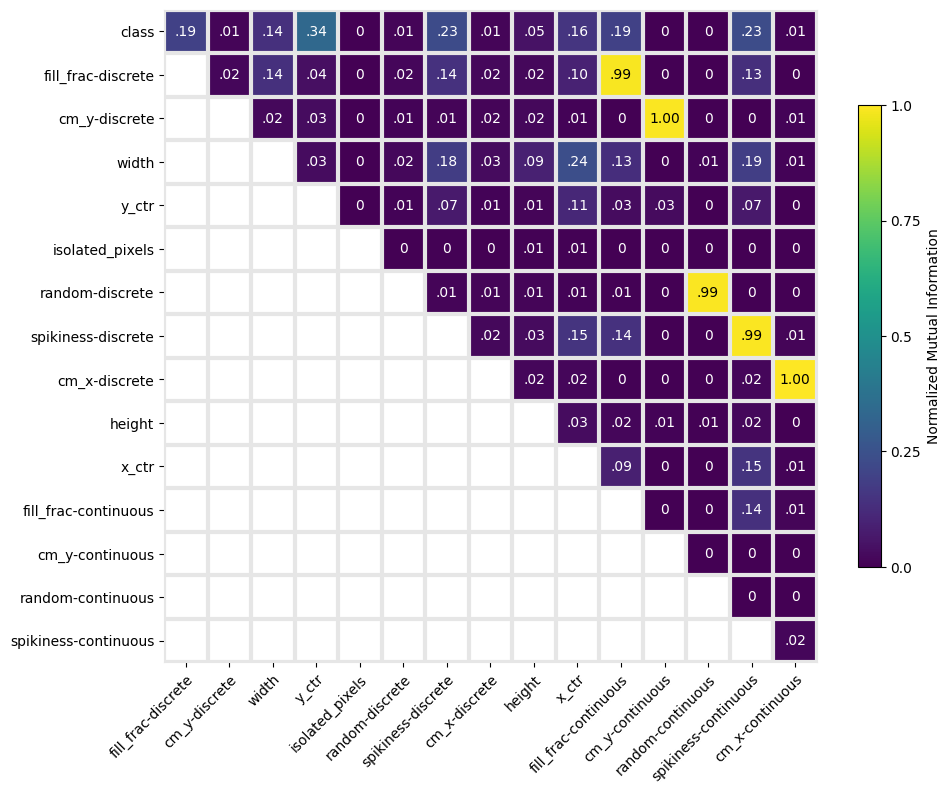

In [12]:
mbalnf.plot();

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super().__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # Mean
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # Log variance

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(len(x), -1))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def vae_loss(x, recon_x, mu, logvar): # BCE for recon, plus KL
    recon_loss = F.binary_cross_entropy(recon_x, x.view(len(x), -1), reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

# try different Loss function for CIFAR-10
def vae_loss2(x, recon_x, mu, logvar):  # MSE for recon, plus KL
    recon_loss = F.mse_loss(recon_x, x.view(len(x), -1), reduction='mean')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss


In [14]:
import torch.nn as nn
import torch.optim as optim

# Create the model
model = VAE(latent_dim=12)

# Define a loss function
criterion = vae_loss


# Create some dummy data
for data in refbb:
    x = data[0]
    break

y = labels



In [23]:
# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 5000
for epoch in (pbar := tqdm(range(epochs))):
# for epoch in range(1000):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    # x_pred, mu_pred, sig_pred = model(x)

    # Calculate forward pass and loss
    loss = criterion(x, *model(x))
    # loss = criterion(x, )

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Print progress
    if epoch % 25 == 0:
        pbar.set_description(f"Epoch: {epoch}, loss: {loss.item():.3f}")


Epoch: 4975, loss: 184876.469: 100%|██████████| 5000/5000 [02:46<00:00, 30.11it/s]


In [24]:
x.shape

torch.Size([2000, 1, 28, 28])

In [16]:
def L2(x, y):
    x, y = x.detach().numpy().reshape((len(x), -1)), y.detach().numpy().reshape((len(y), -1)) 
    return np.sum((x - y)**2, axis=1)

def normdot(x, y): # just correlation except I forogt to remove means
    x, y = x.detach().numpy().reshape((len(x), -1)), y.detach().numpy().reshape((len(y), -1)) 
    xdenom = np.sqrt(np.sum(x*x, axis=1))
    ydenom = np.sqrt(np.sum(y*y, axis=1))

    return np.sum(x*y, axis=1)/(xdenom*ydenom)

def rho(x, y): # correlation for real
    x, y = x.detach().numpy().reshape((len(x), -1)), y.detach().numpy().reshape((len(y), -1)) 
    x -= np.mean(x, axis=1, keepdims=True)
    y -= np.mean(y, axis=1, keepdims=True)
    
    xdenom = np.sqrt(np.sum(x*x, axis=1))
    ydenom = np.sqrt(np.sum(y*y, axis=1))

    return np.sum(x*y, axis=1)/(xdenom*ydenom)


cutoff: 0.60, TP:  0.616, FP: 0.002
cutoff: 0.62, TP:  0.679, FP: 0.003
cutoff: 0.64, TP:  0.745, FP: 0.004
cutoff: 0.66, TP:  0.805, FP: 0.006
cutoff: 0.68, TP:  0.849, FP: 0.007
cutoff: 0.70, TP:  0.879, FP: 0.011
cutoff: 0.72, TP:  0.905, FP: 0.014
cutoff: 0.74, TP:  0.927, FP: 0.021
cutoff: 0.76, TP:  0.944, FP: 0.029
cutoff: 0.78, TP:  0.962, FP: 0.045


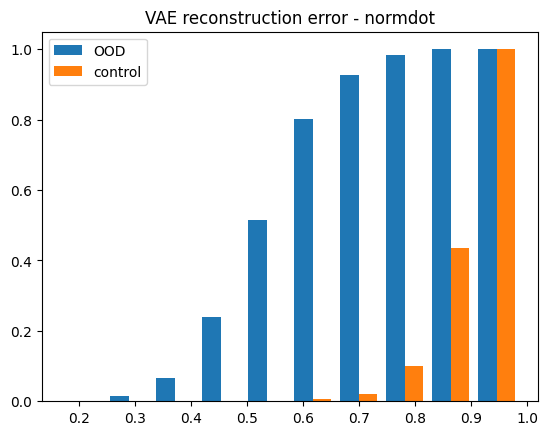

In [22]:
for xval, _, _ in valbb:
    break

xval_pred, _, _ = model(xval)
recon = normdot(xval, xval_pred)

for xcorr,_,_ in corr1bb:
    break
xcorr_pred, _, _ = model(xcorr)
corr_recon = normdot(xcorr_pred, xcorr)

plt.hist((corr_recon, recon), density=True, cumulative=True);
plt.legend(['OOD', 'control'])
plt.title('VAE reconstruction error - normdot');

cutoff = 0.6

for i in range(10):
    is_ood_test = corr_recon < cutoff
    is_ood_ctrl = recon < cutoff
    print(f'cutoff: {cutoff:0.2f}, TP: {np.mean(is_ood_test): 0.3f}, FP: {np.mean(is_ood_ctrl):.3f}')
    cutoff += 0.02



In [ ]:
OOD_detectors = [
    OOD_VAE(VAE(latent_dim=15)),
]
for detector in OOD_detectors:
    print(f"Training {detector.__class__.__name__}...")
    detector.fit(images, threshold_perc=99, epochs=10000, loss_fn=vae_loss, verbose=True, batch_size=2000, optimizer=torch.optim.Adam(detector.model.parameters(), lr=1e-3))

In [ ]:
print(f'threshold instance score is {detector._threshold_score()}')

In [ ]:
results = {type(detector).__name__: np.mean(detector.predict(images).is_ood) for detector in OOD_detectors}
print(results)

In [ ]:
results = {type(detector).__name__: np.mean(detector.predict(val_images).is_ood) for detector in OOD_detectors}
print(results)

In [ ]:
detector._threshold_score()

In [ ]:
dir(detector)

In [ ]:
for x, _, _ in refbb:
    break

for xval, _, _ in valbb:
    break

for xcorr,_,_ in corr1bb:
    break

print(torch.sum(torch.abs(x-xval)))

In [ ]:
import matplotlib.pyplot as plt
import copy

ctrl_scores = copy.deepcopy(detector._ref_score.instance_score)
# val_scores = detector.predict(xval).instance_score
val_scores = detector.predict(val_images).instance_score

detector.predict(xcorr);
expt_scores = detector.predict(xcorr).instance_score

plt.hist((val_scores, expt_scores), 40, cumulative=True, density = True);
plt.legend(['reference', 'corrupted'])

In [ ]:
np.sum(detector.predict(val_images).instance_score < 0.01)

In [ ]:
dir(detector.predict(xcorr))

In [ ]:


results = {type(detector).__name__: np.mean(detector.predict(xcorr).is_ood) for detector in OOD_detectors}
print(results)

In [25]:
model = VAE(latent_dim=12)

In [26]:
def ecdf(data):
    """Compute the empirical cumulative distribution function (ECDF) of a sample."""
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y

def ecdf_ratio(sample1, sample2):
    """Compute the ratio of the ECDFs of two samples."""
    x1, y1 = ecdf(sample1)
    x2, y2 = ecdf(sample2)

    x_all = np.sort(np.concatenate((x1, x2)))
    # Interpolate y values at x_all points
    y1_all = np.interp(x_all, x1, y1)
    y2_all = np.interp(x_all, x2, y2)

    # Compute the ratio of the ECDFs
    ratio = y1_all / y2_all

    return x_all, ratio


In [ ]:
print(x.shape, xval.shape)

In [ ]:
torch.sum(torch.abs(x - xval))

In [ ]:
import matplotlib.pyplot as plt

x_pred, mu_pred, sig_pred = model(xval)

pick = 1234
plt.imshow(np.concatenate((xval[pick].reshape((28,28)), x_pred[pick].detach().numpy().reshape((28,28))), axis=1))

In [ ]:
for xval, _, _ in valbb:
    break

xval_pred, _, _ = model(xval)
recon = L2(xval, xval_pred)

for xcorr,_,_ in corr1bb:
    break

xcorr_pred, _, _ = model(xcorr)
corr_recon = L2(xcorr_pred, xcorr)

plt.hist((corr_recon, recon), density=True, cumulative=True);
plt.legend(['OOD', 'control'])
plt.title('VAE reconstruction error - L2');

cutoff = 30

for i in range(10):
    is_ood_test = corr_recon > cutoff
    is_ood_ctrl = recon > cutoff
    print(f'cutoff: {cutoff:0.2f}, TP: {np.mean(is_ood_test): 0.3f}, FP: {np.mean(is_ood_ctrl):.3f}')
    cutoff += 5


In [ ]:
for xval, _, _ in valbb:
    break

xval_pred, _, _ = model(xval)
recon = rho(xval, xval_pred)

for xcorr,_,_ in corr4bb:
    break
xcorr_pred, _, _ = model(xcorr)
corr_recon = rho(xcorr_pred, xcorr)

plt.hist((corr_recon, recon), density=True, cumulative=True);
plt.legend(['OOD', 'control'])
plt.title('VAE reconstruction error - rho');

cutoff = 0.8

for i in range(10):
    is_ood_test = corr_recon < cutoff
    is_ood_ctrl = recon < cutoff
    print(f'cutoff: {cutoff:0.2f}, TP: {np.mean(is_ood_test): 0.3f}, FP: {np.mean(is_ood_ctrl):.3f}')
    cutoff += 0.02


In [ ]:
cutoff = 0.8

for i in range(10):
    is_ood_test = corr_recon < cutoff
    is_ood_ctrl = recon < cutoff
    print(f'cutoff: {cutoff:0.2f}, TP: {np.mean(is_ood_test): 0.3f}, FP: {np.mean(is_ood_ctrl):.3f}')
    cutoff += 0.02


In [ ]:
pick = 1234
plt.imshow(np.concatenate((xcorr[pick].reshape((28,28)), xcorr_pred[pick].detach().numpy().reshape((28,28))), axis=1))

In [ ]:
plt.plot(*ecdf_ratio(recon, corr_recon))

In [42]:
def ROC_curve(xref, xcorr):
    xref, cref = ecdf(xref)
    xcorr, ccorr = ecdf(xcorr)

    x_all = np.sort(np.concatenate((xref, xcorr)))

    FP = 1.0 - np.interp(x_all, xref, cref)
    TP = 1.0 - np.interp(x_all, xcorr, ccorr)
    iord = np.argsort(FP)

    return FP[iord], TP[iord]

In [43]:
FP, TP = ROC_curve(recon, corr_recon)

In [ ]:
FP[0:10]

In [ ]:
plt.plot(*ROC_curve(recon, corr_recon))
plt.plot([0, 1], [0, 1], 'k:')
plt.gca().set_aspect(1.0)

In [ ]:
FP, TP = ROC_curve(recon, corr_recon)

np.trapz(TP, FP)

In [ ]:
import torchvision
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=200,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [ ]:

for cdata in trainloader:
    break

img = cdata[0][0]  # type: ignore
for i in range(111,115):
    img = np.concatenate((img, cdata[0][i,:,:,:]), axis=2) # type: ignore

img = img.transpose((1, 2, 0))
img = (img + 1.0)/2.0

plt.imshow(img)

In [49]:
cmodel = VAE(input_dim = 3072, latent_dim = 42, hidden_dim = 800) # model(crap[0])
criterion = vae_loss2

In [ ]:
# Define an optimizer
optimizer = torch.optim.Adam(cmodel.parameters(), lr=1e-5)

# Training loop
epochs = 10
for epoch in (pbar := tqdm(range(epochs))):
    for x, _ in trainloader:
        x = (x + 1.0)/2.0
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        # x_pred, mu_pred, sig_pred = model(x)

        # Calculate forward pass and loss
        loss = criterion(x, *cmodel(x))
        # loss = criterion(x, )

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    # Print progress
    pbar.set_description(f"Epoch: {epoch}, loss: {loss.item():.3f}")


In [ ]:
plt.imshow((cdata[0][0].reshape(3, 32, 32).permute(1,2,0)+1)/2.0) # first try

In [ ]:
chk = cmodel(cdata[0])
print(chk[0].shape)
show = (chk[0].reshape((-1,3,32,32)))
show = show.permute(0, 2, 3, 1)
print(show.shape)
plt.imshow(show[0].detach().numpy())

In [ ]:
show[0].min()

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvVAE(nn.Module):
    def __init__(self, latent_dim, input_channels=None):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_channels = 3 if input_channels is None else input_channels

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(self.input_channels, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(32 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(32 * 7 * 7, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, self.input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

def loss_function(x_recon, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [12]:
convmodel = ConvVAE(42)
criterion = loss_function

In [ ]:
from tqdm import tqdm
# Define an optimizer
optimizer = torch.optim.Adam(convmodel.parameters(), lr=1e-9)

# Training loop
epochs = 10
for epoch in (pbar := tqdm(range(epochs))):
    for x, _ in trainloader:
        x = (x + 1.0)/2.0
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        # x_pred, mu_pred, sig_pred = model(x)

        # Calculate forward pass and loss
        x_pred, mu, logvar = convmodel(x)
        loss = criterion(x, x_pred, mu, logvar)
        # loss = criterion(x, )

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    # Print progress
    pbar.set_description(f"Epoch: {epoch}, loss: {loss.item():.3f}")
